# Case 1. Heart Disease (binary) Classification (healthy/sick)

- Author: Lauri Solin
- some code was borrowed from teacher's example (Sakari Lukkanen) 
- link to that example here https://github.com/sakluk/cognitive-systems-for-health-technology/blob/master/Week_2_Case_1_(drafty_notes).ipynb
- student miniproject about neural networks with python
- date started 29.1.2019
- organization: Metropolia University of Applied Sciences

### apparently according to stackOverflow %pylab inline was deprecated 
* and I must admit that it caused 
 warnings in my own code

In [434]:
# Import libraries
#%pylab inline APPARENTLY THIS COMMAND IS DEPRECATED not recc'd to use

import numpy
import matplotlib
from matplotlib import pylab, mlab, pyplot
np = numpy
plt = pyplot

from IPython.core.pylabtools import figsize, getfigs

from pylab import *
from numpy import *


import time
import warnings
import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from keras.utils import to_categorical
from keras import models, layers
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier

### get the data and dataprocessing

* download preprocessed data (for simplicity) about that heart disease from the website


* use preprocessed cleveland data first

* normalize data



* process the data so that the diseased persons are mapped from (1,2,3,4) into (1)


* process the data so that healthy persons are mapped into 0


* randomize the order of the samples in the data (just to be sure)


In [435]:
# download the data first
path1 = r'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(path1,
                 sep=',',
                 header = None,
                 index_col = None,
                 na_values='?')

# check the data downloaded
df.head()

# column names list
c_names = ['age', 'sex', 'cp','trestbps', 'chol', 'fbs','restecg',
             'thalac','exang','oldpeak','slope','ca','thal','num']

# put column names into the df
df.columns = c_names

# replace nan values with medians
df = df.fillna(df.median())

# recheck if nan was replaced,  seems to work, 
# because original data had some lines at the end which had nan values
df.describe()



,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.663366,4.722772,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,1.938383,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


(303, 13) (303,)
235    1.0
198    0.0
54     1.0
234    0.0
3      0.0
84     0.0
145    1.0
23     1.0
69     1.0
292    1.0
71     1.0
90     0.0
1      1.0
65     1.0
236    1.0
162    0.0
257    0.0
181    1.0
287    0.0
217    0.0
247    1.0
167    0.0
37     1.0
207    1.0
271    0.0
268    1.0
264    1.0
189    1.0
82     0.0
166    0.0
      ... 
201    0.0
199    1.0
251    1.0
150    0.0
225    0.0
50     0.0
86     0.0
118    1.0
158    1.0
104    1.0
10     0.0
59     0.0
163    0.0
75     0.0
67     0.0
100    0.0
51     0.0
40     1.0
237    1.0
178    0.0
25     0.0
211    1.0
156    1.0
77     0.0
149    0.0
127    1.0
20     0.0
123    1.0
298    1.0
302    0.0
Name: num, Length: 303, dtype: float64


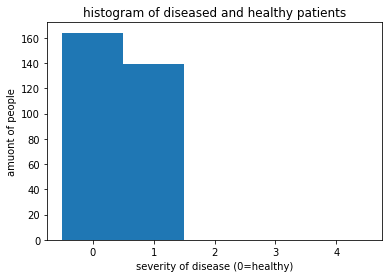

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal
127,0.520833,1.0,1.000000,0.150943,0.257991,0.0,0.0,0.419847,1.0,0.451613,0.5,0.333333,1.0
20,0.729167,1.0,0.000000,0.150943,0.194064,0.0,1.0,0.557252,1.0,0.290323,0.5,0.000000,0.0
123,0.541667,1.0,1.000000,0.433962,0.207763,0.0,0.0,0.305344,1.0,0.903226,1.0,0.000000,1.0
298,0.333333,1.0,0.000000,0.150943,0.315068,0.0,0.0,0.465649,0.0,0.193548,0.5,0.000000,1.0
302,0.187500,1.0,0.666667,0.415094,0.111872,0.0,0.0,0.778626,0.0,0.000000,0.0,0.000000,0.0


In [436]:
# randomize order of datarows (patientdata)
df = shuffle(df)

# normalize data with regard to min and max values
data_min = df.min()
data_max = df.max()
df_norm = (df - data_min)/(data_max - data_min)

# remap the diseased into a single category (healthy=0/sick=1)
# this is the output column (labels)
groundTruth = df_norm['num']
groundTruth = 1.0*(groundTruth > 0.0) 



# I guess, you could just drop the column from the df_norm, just to be sure
# so that df_norm has only the input columns for training & validation
df_norm.drop('num', axis=1, inplace=True)

# check the shapes and values look ok for the dropped labels from df_norm
# and also for the binary labels in the groundTruth series
print(df_norm.shape, groundTruth.shape)
print(groundTruth)

# histogram should have only O's and 1's inside of it
plt.hist(groundTruth, bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
plt.xlabel('severity of disease (0=healthy)')
plt.ylabel('amuont of people')
plt.title('histogram of diseased and healthy patients')
plt.show()

# as can be seen just as a note the df_norm, we dropped that label column
df_norm.tail()

 ## Prepare to train the model
 
 * first, I use cleveland data, and we must divide into training and validation sets
 * 66 % training data
 * 33 % validation data
 * regular validation was used instead of Kfold=5 (I'm trying regular validation first)

 
 
 * I will attempt to start from chollet book chapter_4 IMDB-movie reviews, using 
     1. relu activation
     2. sigmoid at final layer
     3. 16 neuron, 2  layer
     4. optimizers testing two choices adam vs rmsprop
     5. if there is overfitting, change layer dropouts with different percentages

##  preliminary results from testing different options for model

* original 16 neuron, 2 layer was overfitting, so I decided to put both dropoutlayers = 0.4
* rmsprop vs adam there wasn't a huge difference, but I chose adam
* I also reduced amount of epochs from 100 to 50 to reduce overfitting
* batch size 10 seemed to be a good compromise because batch size=1 was ridiculously slow to train (???)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_316 (Dense)            (None, 16)                224       
_________________________________________________________________
dropout_151 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_317 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_152 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_318 (Dense)            (None, 1)                 17        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
Elapsed time: 11.30 seconds


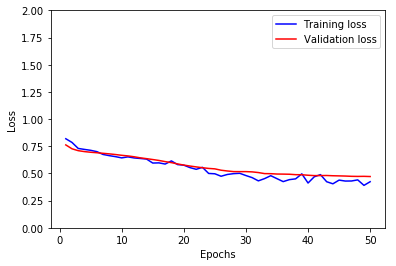

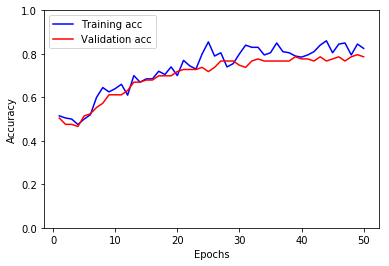

In [437]:
# df_norm should be already randomized & normalized
train_data = df_norm[:200]
validate_data = df_norm[200:]



# get the labels from groundTruth series
# OneHotLabels should not be necessary as it is binary classification
train_labels = groundTruth[:200]
validate_labels = groundTruth[200:]



# build model according to basic format from chollets chapter_4 bin_classification
# of IMDB- movie reviews
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(13,)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

# Compile the model
model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])


# traing the model
t_start = time.time()
history = model.fit(train_data, train_labels, 
                    epochs = 50,
                    batch_size = 10,
                    verbose = 0,
                    validation_data = (validate_data, validate_labels))

t_end = time.time()


print('Elapsed time: {:.2f} seconds'.format(t_end - t_start))

# Get the training data
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)


# Visualize the training process: loss function
plt.figure()
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend()
plt.show()


# Visualize the accuracy
plt.figure()
plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()





## I decided to edit the example code in the confusion matrix part

* I think at this stage, you have to convert the val_predicts into rounded-up/or rounded-down so that the confusion matrix can work with either 1.0 OR 0.0

* I verified that val_predicts should contain the array of outputs from the model (sigmoid-results) and with print() they looked like they were floating point values from 0.0 up to 1.0

* val_predicts = 1*(val_predicts >= 0.5)
* then we simply print out the confusion matrix, 
* because we know the groundTruth, and compare the y_pred into that

* In this way the confusion matrix results seemed more reasonable, as opposed to having y_pred be all zeroes inside as it used to be earlier without that fix

## confusion matrix results, and comparison between simple guess vs neural network

* as was mentioned with the "corrected" y_pred, the results seemed morea reasonable and in alignment with the training and validation accuracy in the graph for example
* simple guess that all patients were healthy was compared against  neural network results from model.predict(df_norm)

In [438]:
# Print total accuracy and confusion matrix
val_predicts = model.predict(df_norm)


y_pred = 1*(val_predicts >= 0.5)
#print("ypred was\n")
#print(y_pred)
#print("ypred was\n")

# confusionMatrix takes first input = groundtruth, second input = predicted values
cm = confusion_matrix(groundTruth, y_pred)

# here we have simple check where we assume that all people are healthy
# then, we check what probability we get with dumb guess

# Normal cases can be counted by summing all labels that are zeros
print('Simple guess accuracy was: {:.4f}'.format(np.sum(groundTruth == 0)/len(groundTruth)))

# Accuracy can be calculated from the confusion matrix by
# counting all elements in diagonal (=trace of the matrix)
print('Total accuracy was: {:.4f}'.format(np.trace(cm)/sum(cm)))
print('Confusion matrix:')
print(cm)



# Calculate precision, recall, fscore and support
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p, r, f, s = precision_recall_fscore_support(groundTruth, y_pred)

# Print precision, recall, fscore and support  
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print('Support:\n', s)
print('Precision:', p)
print('Recall:   ', r)
print('F-score:  ', f)

# We should do something in order to get the accuracy better, but what?

# answer, maybe get more datapoints in the cleveland style?


Simple guess accuracy was: 0.5413
Total accuracy was: 0.8515
Confusion matrix:
[[142  22]
 [ 23 116]]
Support:
 [164 139]
Precision: [ 0.861  0.841]
Recall:    [ 0.866  0.835]
F-score:   [ 0.863  0.838]


## How to get better accuracy, and how to test in more accurate way?

* I only used regular validation and training style
* it is very likely that the test accuracy (total accuracy) will be too high compared to a real "isolated" testing set, because I just applied the network to the test+validation data. model.predict(df_norm)

* possibly Kfold=5 validation will get more accurate validation accuracy values
* more datapoints in cleveland processsed style would have been nice to have
* the reason for the above, was that the swiss, and hungarian datasets were disappointing because that data had so many missing values in many columns, I decided against using that data for those reasons

* possibly the best way would have been to use test_set and train_set, and then just use K-fold crossvalidation and use the test_set that was set aside to test the whole model